In [49]:
import pandas as pd

In [50]:
import numpy as np
import scipy
import sklearn

In [51]:
import sys
print(sys.executable)

/home/beeffjerky/.pyenv/versions/3.11.3/bin/python


In [52]:
review_df = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True)


In [53]:
business_df = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)


In [54]:
review_df = review_df.rename(columns={'stars': 'review_stars', 'type': 'review_type'})
business_df = business_df.rename(columns={'stars': 'business_stars', 'type': 'business_type'})

In [55]:
joinedReviewBusiness = review_df.join(business_df.set_index('business_id'), on='business_id', validate='m:1')

In [74]:
restaurants_df = joinedReviewBusiness[
    joinedReviewBusiness['categories'].apply(lambda x: isinstance(x, list) and 'Restaurants' in x)
].copy()

In [75]:
restaurants_df = restaurants_df[
    restaurants_df['categories'].apply(lambda x: isinstance(x, list) and ('Japanese' in x or 'Chinese' in x or 'Korean' in x))
].copy()

In [76]:
good_restaurants = restaurants_df.copy()


In [77]:
good_restaurants[0:10]

,votes,user_id,review_id,review_stars,date,text,review_type,business_id,full_address,hours,...,city,review_count,name,neighborhoods,longitude,state,business_stars,latitude,attributes,business_type
51,"{'funny': 0, 'useful': 0, 'cool': 0}",u5xcw6LCnnMhddoxkRIgUA,ZYaS2P5EmK9DANxGTV48Tw,5,2010-12-04,I really like both Chinese restaurants in town. This one has outstanding crab rangoon. Love the chicken with snow peas and mushrooms and General Tso Chicken. Food is always ready in 10 minutes which is accurate. Good place and they give you free pop.,review,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}, 'Tuesday': {'close': '22:00', 'open': '11:00'}, 'Friday': {'close': '22:30', 'open': '11:00'}, 'Wednesday': {'close': '22:00', 'open': '11:00'}, 'Thursday': {'close': '22:00', 'open': '11:00'}, 'Sunday': {'close': '21:00', 'open': '16:00'}, 'Saturday': {'close': '22:30', 'open': '11:00'}}",...,De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor Seating': False, 'Attire': 'casual'}",business
52,"{'funny': 0, 'useful': 0, 'cool': 0}",kj18hvJRPLepZPNL7ySKpg,uOLM0vvnFdp468ofLnszTA,3,2011-06-02,Above average takeout with friendly staff. The sauce on the pan fried noodle is tasty. Dumplings are quite good.,review,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}, 'Tuesday': {'close': '22:00', 'open': '11:00'}, 'Friday': {'close': '22:30', 'open': '11:00'}, 'Wednesday': {'close': '22:00', 'open': '11:00'}, 'Thursday': {'close': '22:00', 'open': '11:00'}, 'Sunday': {'close': '21:00', 'open': '16:00'}, 'Saturday': {'close': '22:30', 'open': '11:00'}}",...,De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor Seating': False, 'Attire': 'casual'}",business
53,"{'funny': 0, 'useful': 0, 'cool': 0}",L5kqM35IZggaPTpQJqcgwg,b3u1RHmZTNRc0thlFmj2oQ,4,2012-05-28,"We order from Chang Jiang often and have never been disappointed. The menu is huge, and can accomodate anyone's taste buds. The service is quick, usually ready in 10 minutes.",review,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}, 'Tuesday': {'close': '22:00', 'open': '11:00'}, 'Friday': {'close': '22:30', 'open': '11:00'}, 'Wednesday': {'close': '22:00', 'open': '11:00'}, 'Thursday': {'close': '22:00', 'open': '11:00'}, 'Sunday': {'close': '21:00', 'open': '16:00'}, 'Saturday': {'close': '22:30', 'open': '11:00'}}",...,De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor Seating': False, 'Attire': 'casual'}",business
150,"{'funny': 0, 'useful': 1, 'cool': 0}",_xf2ECTRftPV4bzK4mGYEg,GYpZ9dPzO3vqrr1lXcXi8g,3,2010-02-20,"Good enough for carry-out in McFarland on a cold winter's evening. Ready on time, never had a wrong order, and they're at least reasonably friendly. Would be better if they delivered, but not sure there's a huge demand for it in our tiny burg. They also have a lunch buffet on weekdays for around $6.",review,UgjVZTSOaYoEvws_lAP_Dw,"4850 Larson Beach Rd\nMc Farland, WI 53558",{},...,Mc Farland,8,Main Moon Chinese Restaurant,[],-89.298628,WI,3.5,43.017939,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': {'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}, 'Caters': False, 'Noise Level': 'average', 'Takes Reservations': False, 'Has TV': False, 'Delivery': False, 'Ambience': {'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}, 'Parking': {'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}, 'Wheelchair Accessible': True, 'Outdoor Seating': False, 'Attire': 'casual', 'Alcohol': 'none', 'Waiter Service': False, 'Accepts Credit C

In [78]:
import pandas as pd

cuisine_labels = pd.read_csv('chinese.txt', delimiter="/", header=None, names=["dishes"])

print(cuisine_labels.to_string()) 

                                           dishes
0                                         ABALONE
1                           BAMBOO SHOOT STIR FRY
2                                       BEAN CURD
3                    BEEF SEASONED WITH SOY SAUCE
4                           BEEF STEW WITH RADISH
5                                       BEER DUCK
6                              BEIJING ROAST DUCK
7                                        BISCUITS
8                         BLACK BONE CHICKEN SOUP
9                   BLACK FUNGUS IN VINEGAR SAUCE
10                         BLACK SESAME DUMPLINGS
11                                 BOILED CHICKEN
12      BOILED FISH WITH PICKED CABBAGE AND CHILI
13              BOILED SHREDDED PORK IN CHILI OIL
14                                         BORSCH
15                      BRAISED BEANS WITH POTATO
16                                   BRAISED BEEF
17                            BRAISED BEEF NOODLE
18                           BRAISED CHICKEN FEET


In [79]:
dish_set = set(cuisine_labels['dishes'].str.lower().str.strip())


In [80]:
# 2. Filter good_restaurants to only reviews that mention any dish from the list
def mentions_dish(text):
    if not isinstance(text, str):
        return False
    words = set(text.lower().split())
    return any(dish in text.lower() for dish in dish_set)

# 3. Apply function to filter rows where review contains a dish

good_restaurants_with_dish = good_restaurants[good_restaurants['text'].apply(mentions_dish)].copy()


In [81]:
# 4. Match each review with the dishes it mentions
def extract_mentioned_dishes(text):
    if not isinstance(text, str):
        return []
    text_lower = text.lower()
    return [dish for dish in dish_set if dish in text_lower]


good_restaurants_with_dish['mentioned_dishes'] = good_restaurants_with_dish['text'].apply(extract_mentioned_dishes)

In [82]:
# 5. Explode the list so each row corresponds to one dish
exploded = good_restaurants_with_dish.explode('mentioned_dishes')

# 6. Count total mentions per dish (i.e., total rows with that dish)
dish_counts = exploded['mentioned_dishes'].value_counts().reset_index()
dish_counts.columns = ['dish', 'mention_count']

# 7. Sort by most common
dish_counts = dish_counts.sort_values(by='mention_count', ascending=False)

In [83]:
dish_counts

,dish,mention_count
0,rice,32148
1,eel,7255
2,fried rice,6100
3,crab,4261
4,dim sum,2422
...,...,...
156,chiffon cake,1
157,fish fragrant eggplant,1
158,eight treasure rice,1
159,pork lungs in chili sauce,1


In [84]:
dish_ratings = exploded[['review_stars', 'mentioned_dishes']].groupby('mentioned_dishes').mean()
dish_ratings = dish_ratings.sort_values(by='review_stars', ascending=False)

In [85]:
dish_ratings

,review_stars
mentioned_dishes,
chao fan,5.000000
cold rice noodles,5.000000
braised chicken feet,5.000000
corn cob,5.000000
chiffon cake,5.000000
...,...
biscuits,2.777778
croissant,2.666667
guo tie,2.333333


In [86]:
import nltk


In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [88]:
def get_sentiment_score(text):
    if not isinstance(text, str):
        return None
    return sia.polarity_scores(text)['compound']  # Compound score is a good overall metric

exploded['sentiment_score'] = exploded['text'].apply(get_sentiment_score)

In [96]:
dish_sentiment = (
    exploded.groupby('mentioned_dishes')
    .agg(avg_sentiment_score=('sentiment_score', 'mean'),
         mention_count=('sentiment_score', 'count'))
    .reset_index()
)

dish_sentiment.columns = ['dish', 'avg_sentiment_score', 'mention_count']

In [97]:
dish_sentiment

,dish,avg_sentiment_score,mention_count
0,abalone,0.892800,75
1,almond tofu,0.977617,6
2,bean curd,0.722608,172
3,beef chow fun,0.855217,275
4,beef with broccoli,0.743835,107
...,...,...,...
156,wonton noodle soup,0.726663,164
157,xiao long bao,0.707589,131
158,you tiao,0.553064,11
159,yu xiang rou si,0.806150,2


In [98]:
dish_sentiment.to_csv('dishes.csv', columns=['dish', 'mention_count'], index=False)


In [99]:
# 1. Count total mentions per dish
mention_counts = exploded['mentioned_dishes'].value_counts().reset_index()
mention_counts.columns = ['dish', 'mention_count']

# 2. Compute average sentiment score per dish
avg_sentiment = exploded.groupby('mentioned_dishes')['sentiment_score'].mean().reset_index()
avg_sentiment.columns = ['dish', 'avg_sentiment_score']

# 3. Join the tables on 'dish'
dish_sentiment_summary = mention_counts.merge(avg_sentiment, on='dish', how='inner')

# 4. Sort by mention count
dish_sentiment_summary = dish_sentiment_summary.sort_values(by='mention_count', ascending=False)


dish_sentiment_summary = dish_sentiment_summary.iloc[1:]

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


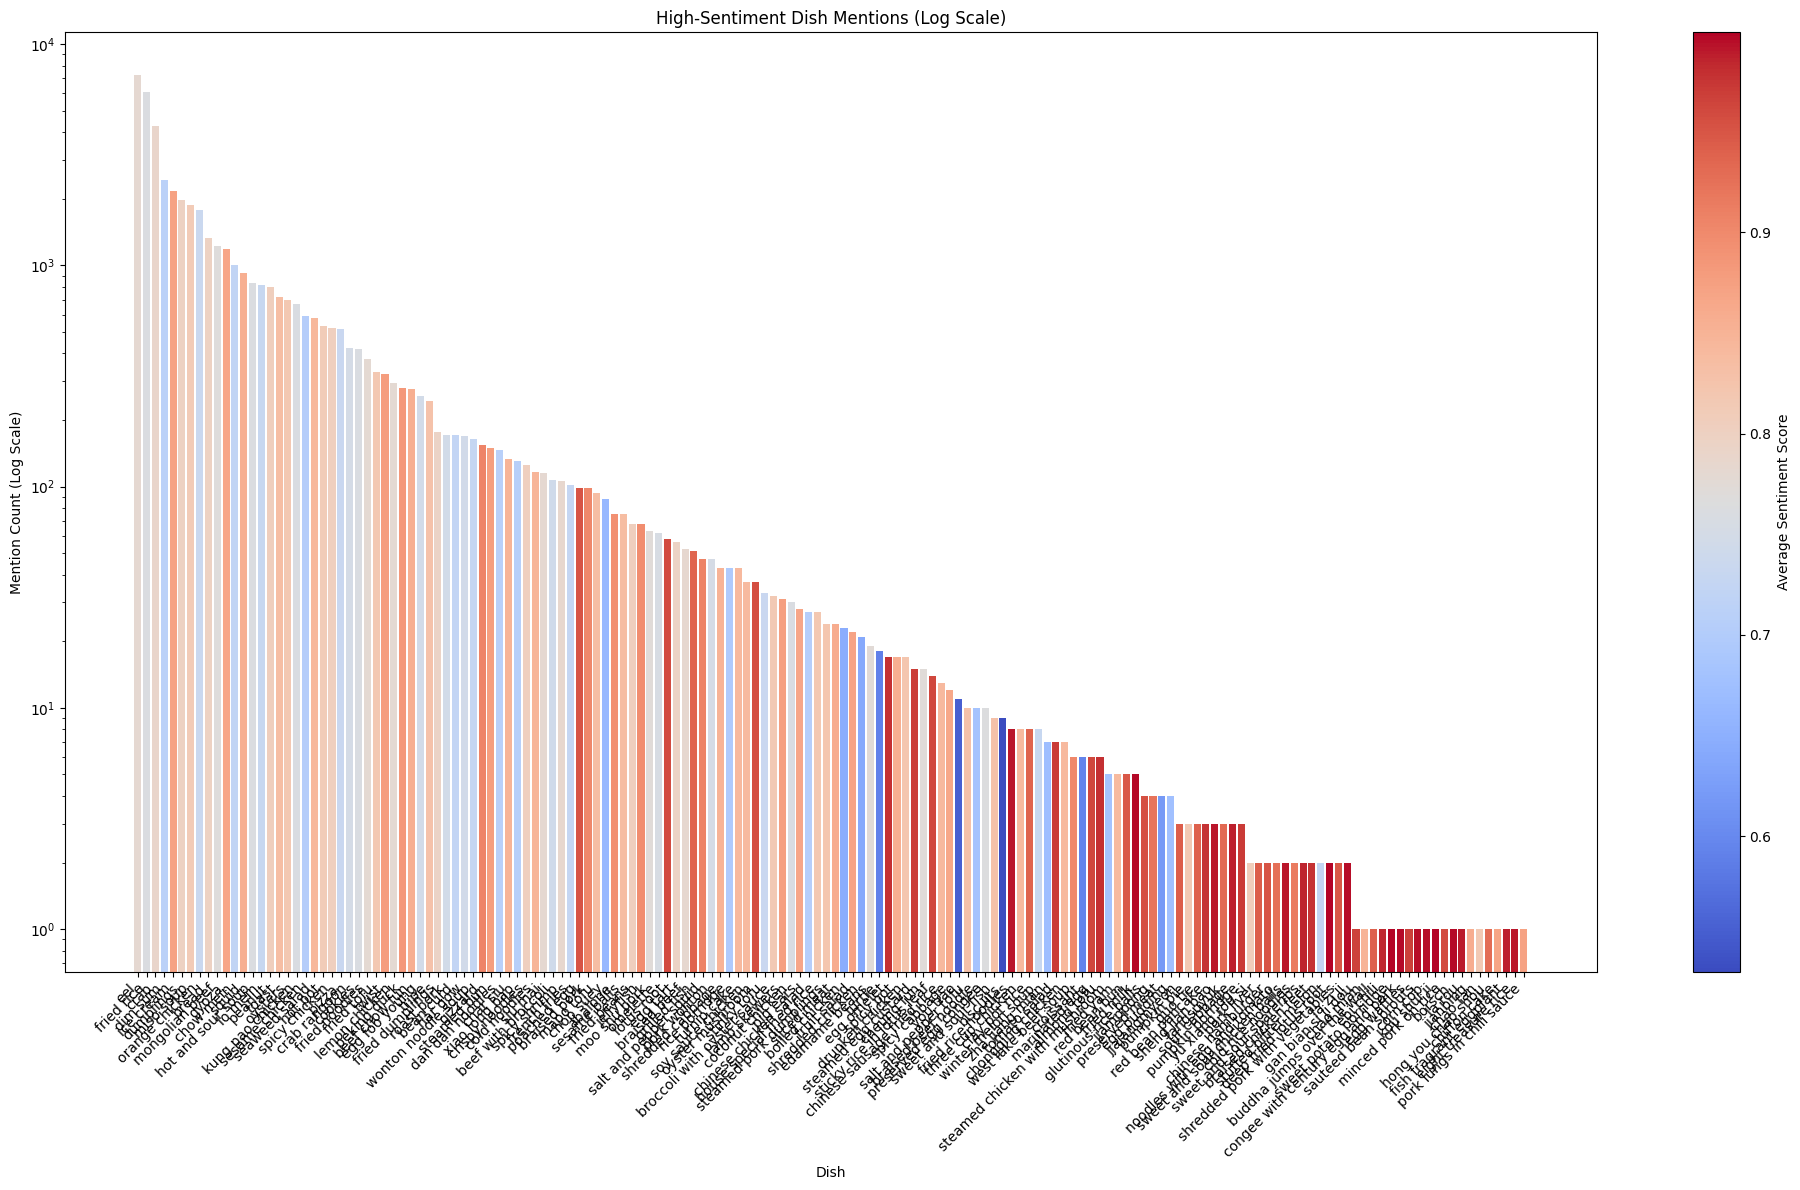

In [101]:
# Recreate the plot with log-scaled y-axis for mention counts

# Filter out dishes with low average sentiment score
# Threshold can be adjusted — here we keep dishes with sentiment > 0.1
filtered_dishes = dish_sentiment_summary[dish_sentiment_summary['avg_sentiment_score'] > 0.5]

# Recreate plot with filtered data
fig, ax = plt.subplots(figsize=(20,12))

# Normalize sentiment scores for coloring
norm = mcolors.Normalize(vmin=filtered_dishes['avg_sentiment_score'].min(),
                         vmax=filtered_dishes['avg_sentiment_score'].max())
cmap = cm.coolwarm
bar_colors = [cmap(norm(score)) for score in filtered_dishes['avg_sentiment_score']]

# Plot bars with log-scaled y-axis
bars = ax.bar(
    filtered_dishes['dish'],
    filtered_dishes['mention_count'],
    color=bar_colors
)

# Set log scale for y-axis
ax.set_yscale('log')

# Fix x-axis labels
ax.set_xticks(range(len(filtered_dishes['dish'])))
ax.set_xticklabels(filtered_dishes['dish'], rotation=45, ha='right')

# Labels and title
ax.set_title("High-Sentiment Dish Mentions (Log Scale)")
ax.set_xlabel("Dish")
ax.set_ylabel("Mention Count (Log Scale)")

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Average Sentiment Score')

plt.tight_layout()
plt.savefig('task4.png')
plt.show()



In [102]:
fried_rice_restaurants = exploded[exploded["mentioned_dishes"] == "fried rice"].copy()


In [103]:
pd.set_option('display.max_colwidth', None)

fried_rice_restaurants[fried_rice_restaurants["name"] == "Waterloo Star"]["text"].to_string()

"999784    Authentic Chinese at a reasonable price. In terms of location, it's about as good as it gets in proximity of UW. The best dish there by far is the Xinjiang Chicken with Rice Noodles. The warm noodles are slathered with a generous helping of spicy chicken chunks and hot peppers and even the regular size is more than enough for dinner and leftovers for the next day. I've also had the fried rice and while it's nothing too special, it's very filling at a very low price (and works great when you're in a pinch, food and money-wise).\\n\\nBe warned however that it is cash only."

In [125]:
import json


In [155]:
def findBestRestaurantsForDish(dish, m=10):
    dish_restaurants = exploded[exploded["mentioned_dishes"] == dish].copy()
    
    # Step 1: Compute average sentiment per restaurant
    restaurant_sentiments = (
        dish_restaurants.groupby(['name', 'full_address', 'business_stars', 'business_id'])
        .agg(
            avg_sentiment_score=('sentiment_score', 'mean'),
            mention_count=('sentiment_score', 'count')
        )
        .reset_index()
    )
    
    # Step 2: Compute global average sentiment for the dish
    global_avg_sentiment = dish_restaurants['sentiment_score'].mean()
    
    # Step 3: Apply Bayesian adjustment
    restaurant_sentiments['bayesian_score'] = (
        (restaurant_sentiments['mention_count'] / (restaurant_sentiments['mention_count'] + m)) * restaurant_sentiments['avg_sentiment_score']
        + (m / (restaurant_sentiments['mention_count'] + m)) * global_avg_sentiment
    )
    restaurant_sentiments = restaurant_sentiments.sort_values(by='bayesian_score', ascending=False).head(100)
    # Step 4: Convert to list of dicts and attach top reviews
    restaurants = restaurant_sentiments.to_dict(orient='records')
    for restaurant in restaurants:
        reviews = dish_restaurants[dish_restaurants['business_id'] == restaurant['business_id']]
        top_reviews = reviews.sort_values(by='sentiment_score', ascending=False).head(5)
        restaurant['top_reviews'] = top_reviews[['text', 'review_stars']].to_dict(orient='records')
    
    return restaurants

fried_rice = findBestRestaurantsForDish("fried rice")

In [156]:
fried_rice[0]

{'name': 'Musashi Japanese Steakhouse',
 'full_address': '3900 Paradise Rd\nEastside\nLas Vegas, NV 89169',
 'business_stars': 4.0,
 'business_id': 'fH5QqIDiwcgEnrSJYuiaaw',
 'avg_sentiment_score': 0.9464864406779662,
 'mention_count': 59,
 'bayesian_score': 0.9196476241387503,
 'top_reviews': [{'text': "Welcome to the finest Japanese restaurant in Las Vegas, possibly the entire country. We have visited this place several times over the past couple years. We are Vegas regulars and go out of our way to visit every time we are in town. \n\nThere are two things that are absolutely outstanding at this restaurant and will blow your mind. First is the service, second is the food. \n\nThe reason we started visiting here was a result of the owner/chef Tsutomu and his previous job. Prior to opening his own restaurant, he worked at the teppan grill in Hamada in the Flamingo. His personality, friendliness and cooking abilities were so impressive that we had to follow him to his new business. Afte

In [144]:

from decimal import Decimal
def float2Decimal(float_value):
    return Decimal(str(float_value))
def yelpToDynamoMapper(restaurant, dishname):
    dynamoItem = {}
    
    dynamoItem['name'] = restaurant['name']
    dynamoItem['address'] = restaurant['full_address']

    dynamoItem['stars'] = float2Decimal(restaurant['business_stars'])
    dynamoItem['sentiment'] = float2Decimal(restaurant['avg_sentiment_score'])
    dynamoItem['mentions'] = restaurant['mention_count']
    dynamoItem['PK'] = dishname
    dynamoItem['SK'] = str(restaurant['avg_sentiment_score']) + "%#%"+ restaurant['business_id']
    dynamoItem['reviews'] = [{"text": review['text'], "stars": float2Decimal(review['review_stars'])} for review in restaurant['top_reviews']]
    return dynamoItem
    


In [145]:
from boto3.dynamodb.types import TypeDeserializer, TypeSerializer


In [146]:
def dynamo_to_python(dynamo_object):
    deserializer = TypeDeserializer()
    return {
        k: deserializer.deserialize(v) 
        for k, v in dynamo_object.items()
    }  

def python_to_dynamo(python_object):
    serializer = TypeSerializer()
    return {
        k: serializer.serialize(v)
        for k, v in python_object.items()
    }

In [147]:
python_to_dynamo(yelpToDynamoMapper(fried_rice[0], "FRIED RICE"))

{'name': {'S': '1 Eastern Super Buffet'},
 'address': {'S': '1901 S Signal Butte Rd\nSte 101\nMesa, AZ 85209'},
 'stars': {'N': '3.5'},
 'sentiment': {'N': '0.9575'},
 'mentions': {'N': '1'},
 'PK': {'S': 'FRIED RICE'},
 'SK': {'S': '0.9575%#%BpMdiKy1Pf5VdBouzuui4A'},
 'reviews': {'L': [{'M': {'text': {'S': "Rand H. has gotten me curious about these buffets he loves so much so off we went to for another super lunch. Claire and I met up with Robyn N. and had a nice leisurely lunch.  \n\nThe location is a bit tricky.  It's on the side of LA Fitness so if you turn into the parking lot go past the front of LA Fitness and turn left.  It's in the corner of the strip mall.  Robyn beat us there so thankfully she texted me to tell me where it was otherwise I would have gone in circles.  My sense of direction is not so good.  :(\n\nEverything is super clean and the restaurant itself is nice.  The service was very good, our drinks were always full and plates clearned promptly.\n\nThe food was goo

In [149]:
import boto3
import os
dynamodb = boto3.client(
        'dynamodb',
        aws_access_key_id=os.environ['DYNAMO_RW_KEY'],
        aws_secret_access_key=os.environ['DYNAMO_RW_SECRET_KEY'],
        region_name='us-east-2'
    )

In [151]:
dynamodb.put_item(
    TableName='restaurant_dish_table',
    Item=python_to_dynamo(yelpToDynamoMapper(fried_rice[0], "FRIED RICE"))
)

{'ResponseMetadata': {'RequestId': 'FN8SIGPJDUGB8BCA6MVD3NC47JVV4KQNSO5AEMVJF66Q9ASUAAJG',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Thu, 31 Jul 2025 20:17:25 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'FN8SIGPJDUGB8BCA6MVD3NC47JVV4KQNSO5AEMVJF66Q9ASUAAJG',
   'x-amz-crc32': '2745614147'},
  'RetryAttempts': 0}}

In [157]:
def process_dish(dish):
    restaurants = findBestRestaurantsForDish(dish)
    dynamoDish = dish.upper()

    # DynamoDB allows up to 25 items per batch
    MAX_BATCH_SIZE = 25
    items = []

    for restaurant in restaurants:
        item = python_to_dynamo(yelpToDynamoMapper(restaurant, dynamoDish))
        items.append({
            'PutRequest': {
                'Item': item
            }
        })

    # Break into batches of 25
    for i in range(0, len(items), MAX_BATCH_SIZE):
        batch = items[i:i + MAX_BATCH_SIZE]
        request_items = {
            'restaurant_dish_table': batch
        }
        response = dynamodb.batch_write_item(RequestItems=request_items)

        # Retry unprocessed items
        while 'UnprocessedItems' in response and response['UnprocessedItems']:
            response = dynamodb.batch_write_item(RequestItems=response['UnprocessedItems'])
process_dish("fried rice")

In [160]:
for index, row in dish_sentiment.iterrows():
    print(row['dish'])
    process_dish(row['dish'])

abalone
almond tofu
bean curd
beef chow fun
beef with broccoli
biscuits
boiled chicken
borsch
braised beef
braised beef noodle
braised chicken feet
braised pork
bread
broccoli with oyster sauce
buddha jumps over the wall
chao fan
chao mian
char siu
cheung fun
chiffon cake
chinese chicken salad
chinese hamburger
chinese sausage fried rice
chongqing chicken
chop suey
chow mein
clay pot rice
coconut chicken
cold noodles
cold rice noodles
congee with century egg and pork
cookies
corn cob
crab
crab rangoon
crispy noodles
croissant
dan dan noodles
deep fried lotus root
dim sum
drunken chicken
dumplings
ebi chili
edamame beans
eel
egg foo young
egg omelet
egg pudding
egg tart
egg waffles
eight treasure rice
fish fragrant eggplant
french fries
fried beans
fried dumplings
fried milk
fried noodles
fried rice
fried rice noodles
fried tofu
fried yam
fruit salad
gan bian si ji dou
gizzard
glutinous rice balls
grilled fish
guo tie
gyoza
har gow
hong you chao shou
hot and sour soup
hot pot
house spec